# Create a Machine Learning Model for Unsupervised Text Topic Classification
Part 1 of 2
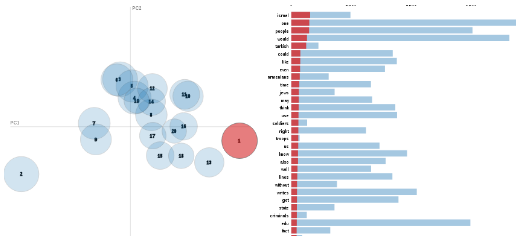
## Introduction
In this tutorial notebook we will use the <a href="https://radimrehurek.com/gensim/about.html" target="_blank" rel="noopener noreferrer">gensim</a> library to create a <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation" target="_blank" rel="noopener noreferrer">Latent Dirichlet allocation (LDA)</a> machine learning <a href="https://en.wikipedia.org/wiki/Topic_model" target="_blank" rel="noopener noreferrer">topic model</a>. LDA is an _unsupervised_ model, so the topics which are identified during training are assigned a number (for a _label_) and described by a group of terms, where each term is coupled with a weight.

We will use a sample newsgroup dataset <a href="https://rare-technologies.com/new-api-for-pretrained-nlp-models-and-datasets-in-gensim/" target="_blank" rel="noopener noreferrer">provided by gensim</a> for the purposes of training and scoring.
***
This is part 1 of this tutorial notebook series, where we will perform the following:
* create/train the model
* visualize it with <a href="http://pyldavis.readthedocs.io/en/latest/" target="_blank" rel="noopener noreferrer">pyLDAvis</a>
* save the model on __IBM Cloud Object Storage__.

<font color=red>**UPDATE LINK!!!**</font>  
In [part 2](https://dataplatform.ibm.com/analytics/notebooks/v2/abf17c29-ff75-4b59-a67c-411eda75e547/view?access_token=d82dd17f147bce9084bda230a4243133ab3f27cd29baf3a0fad750e7e03e3aee), we will create a __Streams Flow__ using __Streams Designer__, which uses the model to perform real-time topic classification on news items from the dataset. The results will be also be saved to __IBM Cloud Object Storage__.

Some familiarity with Python is recommended. This notebook has been verified for Python 3.5, Spark 2.1 and gensim 2.2.

## <a id="TOC"></a> Table of contents
1. [Setup](#setup)<br>
    1.1 [Import / Install prerequisite packages](#setup1)<br>
    1.2 [Provide Credentials for Cloud Object Storage (COS)](#setup2)<br>
    1.3 [Provide COS bucket and object names](#setup3)<br>
    1.4 [Download the sample dataset](#setup4)<br>
2. [Define functions](#define)<br>
    2.1 [function: read_dataset](#define1)<br>
    2.2 [function: preprocess_texts](#define2)<br>
    2.3 [function: train_model](#define3)<br>
    2.4 [function: package_model](#define4)<br>
    2.5 [function: save_to_cos](#define5)<br>
3. [Create the model](#train)<br>
4. [Display the topic model visualization](#visualize)<br>
5. [Save the model and topic terms to Cloud Object Storage](#save)<br>
6. [Summary and next steps](#summary)<br>

<a id="setup"></a>
## 1. [Setup](#TOC)

<a id="setup1"></a>
### 1.1 [Install prerequisite packages](#TOC)
Make sure that these packages are installed. To install:
* Un-comment the _pip install_ commands and _Run_ the cell.
* Restart the kernel (preferably _Restart and Clear Output_).
* Return the comments to the commands (since they will be unnecessary the next time your run the notebook).

It is recommended to install gensim version 2.2 as this is the version installed on the _IBM Cloud Streaming Analytics_ service at the time this notebook was tested.

In [1]:
#!pip install --user gensim==2.2

#!pip install --user pyLDAvis

<a id="setup2"></a>
### 1.2 [Provide Credentials for Cloud Object Storage (COS)](#TOC)
The COS credentials will be used at the end of this tutorial for storing the created model.

You can copy your credentials from the __IBM Cloud Dashboard__ `Service credentials` page of your __Cloud Object Storage__  service.

You can replace the entire content of the **cos_credentials** variable with your credentials, or provide only your <font color=blue>'apikey'</font> and rely on the defaults used in the **save_to_cos** function.  
Make sure that the <font color=red>_name_</font> of the credentials variable is set to **cos_credentials**.

In [2]:
# @hidden_cell
#INSERT YOUR COS CREDENTIALS
cos_credentials = {
  "apikey": "<REPLACE>",
}

<a id="setup3"></a>
### 1.3 [Provide COS bucket and object names](#TOC)
Choose a COS bucket name and object names for your packaged model (.gz) and topic-terms (.csv) files. 
<font color=red>Be sure that the bucket already exists!</font>

In [3]:
model_bucket_name = 'pyml'
model_object_name = 'LDA_news.model.pkg.gz'
topic_object_name = 'LDA_news.topic_terms.csv'

<a id="setup4"></a>
### 1.4 [Download the sample dataset](#TOC)
Version 3.2 of gensim (December 2017) includes a mechanism for [downloading](https://radimrehurek.com/gensim/downloader.html) some sample datasets.
Even if you have a previous version of gensim, you can still download the sample dataset directly from the gensim (RaRe-Technologies) github repository (based on the source code at https://github.com/RaRe-Technologies/gensim/blob/master/gensim/downloader.py).

We will use the __20-newsgroup__ dataset, which is described as: "The notorious collection of approximately 20,000 newsgroup posts, partitioned (nearly) evenly across 20 different newsgroups."

In [4]:
DOWNLOAD_BASE_URL = "https://github.com/RaRe-Technologies/gensim-data/releases/download"
dataset="20-newsgroups"

#!rm -f {dataset}.gz*
![[ ! -f {dataset}.gz ]] && wget '{DOWNLOAD_BASE_URL}/{dataset}/{dataset}.gz'
!pwd && ls -l {dataset}.gz*

/gpfs/fs01/user/sca9-7277eb31bca08b-bc196c953de3/notebook/work
-rw------- 1 sca9-7277eb31bca08b-bc196c953de3 users 14483581 Nov  9 17:44 20-newsgroups.gz


<a id="define"></a>
## 2. [Define functions](#TOC)

<a id="define1"></a>
### 2.1 [function: read_dataset](#TOC)
Load the dataset and create a List of texts. (All stored in memory, so assume a small dataset.) 
The dataset file should be in JSON format and contain a key called **data**.

Parameters:
* dataset_path: Path and filename of the dataset file.
* max_lines: If greater than 0, abort reading the file after max_lines lines.

Returns:
* texts: List of the text documents.

In [5]:
def read_dataset(dataset_path, max_lines=0):
    from smart_open import smart_open
    import json

    print("opening...", dataset_path)
    
    texts = []
    with smart_open( dataset_path, 'rb') as infile:
        for i, line in enumerate(infile):
            if max_lines > 0 and i == max_lines:
                break
            jsonData = json.loads(line.decode('utf8'))
            texts.append(jsonData['data'])

    print(len(texts), "lines read")

    return texts

<a id="define2"></a>
### 2.2  [function: preprocess_texts](#TOC)
Steps to pre-process and cleanse texts:
1. Stopword Removal.
2. Collocation detection (bigram).
3. Lemmatization (not stem since stemming can reduce the interpretability).
    
Parameters:
* texts: List of texts.
* stoplist: List of stopword tokens (from _nltk.corpus.stopwords.words('english')_).
* lemmatizer: [optional] Lemmatizer (from _nltk.stem.WordNetLemmatizer()_).    

Returns:
* tokens: Pre-processed tokenized texts.
* bigram_phraser: The bigram phraser which was created using all of the training data.

In [6]:
# Adapted from https://github.com/RaRe-Technologies/gensim/blob/master/docs/notebooks/gensim_news_classification.ipynb
def preprocess_texts(texts, stoplist, lemmatizer=None):
    from gensim import utils, models
    import re

    # Convert to lowercase, remove accents, punctuation and digits. Tokenize and remove stop-words and header fields. re.sub( r'[^ @]+@[^ @]+', '', x)
    tokens = [[word for word in utils.tokenize(re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text),
                                              lowercase=True, deacc=True, errors="ignore")
                     if word not in stoplist and len(word) > 2]
               for text in texts]

    # bigram collocation detection
    bigram = models.Phrases(tokens)
    bigram_phraser = models.phrases.Phraser(bigram)
    tokens = [bigram_phraser[text] for text in tokens]

    if lemmatizer:
        tokens = [[word for word in lemmatizer.lemmatize(' '.join(text), pos='v').split()] for text in tokens]

    return tokens, bigram_phraser

<a id="define3"></a>
### 2.3 [function: train_model](#TOC)
Steps to create the model:
1. Create a Dictionary using the List of cleansed tokenized text.
2. [optional] Filter extremes.
3. Create a corpus from the Bag-of-Words method.  
    The BOW method takes the text tokens (words) and returns a list of tuples containing
    the word's token-id within the dictionary, and it's frequency within the input text.
4. Create and train an LDA model. Play around with the hyperparameters to affect speed and quality.

Parameters:
* textTokens: List of cleansed documents, where each document is represented by a List of tokens.

Results:
* model: The trained LDA model.
* dictionary: The dictionary created from the tokenized text.
* textBOW: The corpus used in creating the model

In [7]:
def train_model(textTokens):
    from gensim import corpora, models

    # Create the dictionary
    dictionary = corpora.Dictionary( documents=textTokens)
    
    # Optional: Filter out tokens which are in less than 10 and more than 75.0% of the documents
    dictionary.filter_extremes(no_below=10, no_above=0.75, keep_n=50000)

    # The training corpus is the result of the Bag-of-Words method.
    textBOW = [dictionary.doc2bow(text) for text in textTokens]

    # Create the gensim LDA model. Choose the best hyper-parameters. For example, try: iterations=100, passes=3
    model = models.ldamodel.LdaModel( corpus=textBOW, id2word=dictionary,
                                      num_topics=20, update_every=0.5,
                                      iterations=10, passes=1) # RECOMMENDED ONLY FOR FASTER TESTING

    return model, dictionary, textBOW

<a id="define4"></a>
### 2.4 [function: package_model](#TOC)
Package the model, phraser and creation timestamp into a pickled (serialized) and gzip-ed object.

Parameters:
* model: The LDA model
* phraser: [optional] The bigram phraser

Results:
* timestamp: The package creation timestamp
* pkg_gz: The compressed package

In [8]:
def package_model(model, phraser=None):
    import pickle, gzip
    from time import strftime

    timestamp = strftime('%Y-%m-%d_%H.%M.%S')
    pkg = { 'timestamp': timestamp,
            'model': model,
            'phraser': phraser
          }
    pkg_gz = gzip.compress(pickle.dumps(pkg))
    
    return timestamp, pkg_gz

<a id="define5"></a>
### 2.5 [function: save_to_cos](#TOC)
Save an object to Cloud Object Storage (COS) using the REST API.

Parameters:
* cred: Dictionary of COS credentials. It may contain various key names, depending on where the credentials were copied from.
* bucket_name: COS bucket_name (must already exist!)
* object_name: Name of object to write.
* data: Serialized data to write.

In [9]:
def save_to_cos( cred, bucket_name, object_name, data):
    import requests

    default_iam_url = 'https://iam.ng.bluemix.net/oidc/token'
    default_endpoint = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'
    
    api_key = cred.get('apikey', cred.get('api_key', cred.get('IBM_API_KEY_ID')))
    iam_url = cred.get('iam_url', cred.get('IBM_AUTH_ENDPOINT', default_iam_url))
    endpoint = cred.get('url', cred.get('ENDPOINT', default_endpoint))

    if not api_key:
        print("ERROR: Missing api key")
        return

    full_object_path = bucket_name + "/" + object_name
    print("Saving", full_object_path, "(", str(len(data)), "bytes)")

    response = requests.post(
                url = iam_url,
                headers = {"Content-Type": "application/x-www-form-urlencoded"},
                params = {"grant_type":"urn:ibm:params:oauth:grant-type:apikey","apikey":api_key},
                verify = True)
    if response.status_code != 200:
        print( "ERROR: POST Response =", response.status_code, response.reason, response.text)
        return
    bearer_token = response.json()["access_token"]
    
    response = requests.put(
                url = endpoint + "/" + full_object_path,
                headers = {"Authorization": "bearer " + bearer_token},
                data = data)    
    if response.status_code != 200:
        print( "ERROR: PUT Response =", response.status_code, response.reason, response.text)

<a id="train"></a>
## 3. [Create the model](#TOC)

The following steps will be performed:
* Download the NLTK collection of stop words.
* Download the NLTK lemmatizer used in pre-processing the text.
* Read a subset of the sample dataset to use for training.
* Pre-process and cleanse the text data.
* Train the LDA model.
* Display some of the topic terms identified by the model.

### Ignore deprication warnings.  
[Optional] Set the logging level to display more or less messages. The gensim library provides many interesting progress messages.
* Change the default level to _logging.ERROR_ to see fewer messages. Valid levels are: _CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET_
* You can change the level at any time with these commands:
```
logger = logging.getLogger()
logger.setLevel( logging.ERROR)
```

In [10]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning')

# Optional: Set the default logging level.
import logging
logging.basicConfig( level=logging.INFO, format='%(asctime)s : %(name)s.%(funcName)s : %(levelname)s : %(message)s')

### Load the stoplist and lemmatizer

In [11]:
import nltk
from sklearn.feature_extraction import stop_words
from stop_words import get_stop_words

nltk.download("wordnet")
lemmatizer = nltk.stem.WordNetLemmatizer()

# sklearn has 318 stop words
stoplist = set(stop_words.ENGLISH_STOP_WORDS)
print("Stop words:", len(stoplist))

# nltk has 179 stop words
nltk.download("stopwords")
stoplist.update(nltk.corpus.stopwords.words("english"))
print("Stop words:", len(stoplist))

# stop_words has 174 stop words
stoplist.update(get_stop_words('english'))
print("Stop words:", len(stoplist))

# sklearn (318) + nltk(179) = 378 + stop_words(174) = 407

#stoplist.update({"MANUALLY", "ADDED", "STOP WORDS"})

[nltk_data] Downloading package stopwords to /gpfs/fs01/user/sca9-7277
[nltk_data]     eb31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /gpfs/fs01/user/sca9-7277eb
[nltk_data]     31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Train the model

In [12]:
# The 20-newsgroups dataset has 18846 entries. Let's take 5000 for training (this is not necessary a recommended ratio).
texts = read_dataset(dataset + ".gz", 5000)

# Pre-process and cleanse the texts
%time textTokens, bigram_phraser = preprocess_texts( texts, stoplist, lemmatizer)

# train the model (save the dictionary and corpus for visualization)
%time model, dictionary, corpus = train_model( textTokens)

# Retrieve the topic terms from the model
topicTerms = model.print_topics(num_topics=-1, num_words=20)

opening... 20-newsgroups.gz
5000 lines read


Using TensorFlow backend.
2018-01-17 09:34:09,335 : summa.preprocessing.cleaner.<module> : INFO : 'pattern' package not found; tag filters are not available for English
2018-01-17 09:34:14,278 : gensim.models.phrases.learn_vocab : INFO : collecting all words and their counts
2018-01-17 09:34:14,281 : gensim.models.phrases.learn_vocab : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-01-17 09:34:15,764 : gensim.models.phrases.learn_vocab : INFO : collected 511194 word types from a corpus of 835271 words (unigram + bigrams) and 5000 sentences
2018-01-17 09:34:15,768 : gensim.models.phrases.add_vocab : INFO : using 511194 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2018-01-17 09:34:15,769 : gensim.models.phrases.__init__ : INFO : source_vocab length 511194
2018-01-17 09:34:20,499 : gensim.models.phrases.__init__ : INFO : Phraser built with 11621 11621 phrasegrams
2018-01-17 09:34:26,252 : gensim.corpora.dictionary.add_

CPU times: user 41.7 s, sys: 1.75 s, total: 43.5 s
Wall time: 43.6 s


2018-01-17 09:34:27,515 : gensim.corpora.dictionary.add_documents : INFO : built Dictionary(57019 unique tokens: ['anybody_knows', 'gregb', 'ramons', 'circle', 'ogil']...) from 5000 documents (total 726457 corpus positions)
2018-01-17 09:34:27,617 : gensim.corpora.dictionary.filter_extremes : INFO : discarding 47709 tokens: [('prevelant', 1), ('barred', 6), ('slaughter_innocent', 9), ('mete', 2), ('everlasting', 3), ('purgatory', 3), ('militarily', 3), ('calvinists', 1), ('gommorrah', 1), ('foreknew', 1)]...
2018-01-17 09:34:27,618 : gensim.corpora.dictionary.filter_extremes : INFO : keeping 9310 tokens which were in no less than 10 and no more than 3750 (=75.0%) documents
2018-01-17 09:34:27,644 : gensim.corpora.dictionary.filter_extremes : INFO : resulting dictionary: Dictionary(9310 unique tokens: ['mad', 'beth', 'early_christians', 'manipulate', 'circle']...)
2018-01-17 09:34:28,416 : gensim.models.ldamodel.init_dir_prior : INFO : using symmetric alpha at 0.05
2018-01-17 09:34:28,4

2018-01-17 09:35:00,448 : gensim.models.ldamodel.show_topics : INFO : topic #4 (0.050): 0.009*"one" + 0.005*"use" + 0.005*"people" + 0.004*"would" + 0.004*"may" + 0.004*"system" + 0.003*"could" + 0.003*"like" + 0.003*"also" + 0.003*"many" + 0.003*"used" + 0.003*"us" + 0.003*"key" + 0.003*"think" + 0.002*"know" + 0.002*"even" + 0.002*"way" + 0.002*"see" + 0.002*"organization" + 0.002*"lines"
2018-01-17 09:35:00,449 : gensim.models.ldamodel.show_topics : INFO : topic #5 (0.050): 0.018*"nsa" + 0.009*"one" + 0.007*"people" + 0.006*"would" + 0.004*"organization" + 0.004*"think" + 0.004*"writes" + 0.004*"com" + 0.004*"edu" + 0.004*"know" + 0.004*"get" + 0.004*"first" + 0.003*"well" + 0.003*"said" + 0.003*"crimes" + 0.003*"two" + 0.003*"good" + 0.003*"see" + 0.003*"israel" + 0.003*"government"
2018-01-17 09:35:00,450 : gensim.models.ldamodel.show_topics : INFO : topic #6 (0.050): 0.019*"armenian" + 0.009*"people" + 0.006*"would" + 0.006*"edu" + 0.006*"armenians" + 0.005*"wiretap" + 0.005*"b" 

CPU times: user 32.1 s, sys: 59.6 s, total: 1min 31s
Wall time: 34.2 s


In [13]:
# Display a sampling of the identified topic terms
for tt in topicTerms[:5]:
    print("Topic={0}, Terms={1}...".format(tt[0],tt[1][:120]), end="\n\n")

Topic=0, Terms=0.007*"one" + 0.005*"edu" + 0.005*"organization" + 0.005*"com" + 0.005*"arab" + 0.004*"also" + 0.004*"people" + 0.004*"g...

Topic=1, Terms=0.009*"people" + 0.006*"would" + 0.005*"get" + 0.005*"edu" + 0.005*"writes" + 0.005*"one" + 0.004*"com" + 0.004*"know" +...

Topic=2, Terms=0.013*"would" + 0.011*"des" + 0.009*"one" + 0.006*"people" + 0.004*"right" + 0.004*"organization" + 0.004*"could" + 0.00...

Topic=3, Terms=0.010*"government" + 0.009*"would" + 0.007*"people" + 0.005*"one" + 0.005*"organization" + 0.004*"israel" + 0.004*"know"...

Topic=4, Terms=0.009*"one" + 0.005*"use" + 0.005*"people" + 0.004*"would" + 0.004*"may" + 0.004*"system" + 0.003*"could" + 0.003*"like"...



The result of the above command displays a topic number followed by a group of terms, where each term is coupled with its weight within the topic.

<a id="visualize"></a>
## 4. [Display the topic model visualization](#TOC)
We will use the pyLDAvis, which you can read about at http://pyldavis.readthedocs.io/en/latest/ and https://github.com/bmabey/pyLDAvis.

When the display is ready, you can use the interactive visualization to explore the dominant terms of the topics.

In [15]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare( model, corpus, dictionary)

pyLDAvis.display(vis)

<a id="save"></a>
## 5. [Save the model and topic terms to Cloud Object Storage](#TOC)
* Package the model and phraser into a dictionary object, which can be serialized and compressed to a file.
* Save the file to COS.

In [16]:
# Package the model and phraser into a gzip object
ts, pkg_gz = package_model( model, bigram_phraser)
print("Package size: {} bytes; creation timestamp: {}".format(len(pkg_gz), ts))

# Stick the model creation timestamp into the name of the topic-terms file name
topic_object_name_ts = topic_object_name.replace('.csv','') + '.' + ts + '.csv'
print("Modified topic file name: {}".format(topic_object_name_ts))

Package size: 3317174 bytes; creation timestamp: 2018-01-17_09.48.09
Modified topic file name: LDA_news.topic_terms.2018-01-17_09.48.09.csv


In [17]:
# Write both files to COS
save_to_cos( cos_credentials, model_bucket_name, model_object_name, pkg_gz)

save_to_cos( cos_credentials, model_bucket_name, topic_object_name_ts, 
                '\n'.join([str(t[0]) + "," + t[1] for t in topicTerms]))

Saving pyml/LDA_news.model.pkg.gz ( 3317174 bytes)
Saving pyml/LDA_news.topic_terms.2018-01-17_09.48.09.csv ( 6358 bytes)


<a id="summary"></a>
## 6. [Summary and next steps](#TOC)

You have now created an LDA model and saved it to Cloud Object Storage.

<font color=red>**UPDATE LINK!!!**</font>  
Proceed to [part 2](https://dataplatform.ibm.com/analytics/notebooks/v2/abf17c29-ff75-4b59-a67c-411eda75e547/view?access_token=d82dd17f147bce9084bda230a4243133ab3f27cd29baf3a0fad750e7e03e3aee), to create a __Streams Flow__ using the __Streams Designer__, which uses the model we created to perform real-time topic classification on news items from the dataset.

### <a id="authors"></a>Authors
**Raanon Reutlinger** is a developer at IBM Cloud Developer Services, working on the __Streams Designer__ IBM Cloud service. Raanon has over 20 years experience in the IBM Software Group, working in Data Management, Big Data and Watson teams.
<hr>
Copyright &copy; IBM Corp. 2017,2018. This notebook and its source code are released under the terms of the MIT License.